In [1]:
import pandas as pd
import numpy as np
from glob import glob
from transformers import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics
import os

from model_1_to_1 import (
    BertChineseLinearPunc,
    BertChineseCNNreplaceBert,
    BertChineseBigStrideCNN,
    BertChineseSlimCNNBert,
    BertChineseLSTMLinearPunc,
)
from data_1_to_1 import load_file, preprocess_data, create_data_loader

### Model path

In [2]:
glob('models/*')

['models/bert-base-uncased.tar.gz',
 'models/config.json',
 'models/pytorch_model.bin',
 'models/vocab.txt',
 'models/1_albert_dense_noRnn',
 'models/1_albert_dense_rnn',
 'models/1_albert_small_dense_hidden_UniRNN',
 'models/albert_chinese_small',
 'models/albert_chinese_tiny',
 'models/albert_en',
 'models/bart_tiny',
 'models/bert_distill_chinese',
 'models/distillbert',
 'models/distillroberta_tiny',
 'models/2-BertChineseLinearPunc',
 'models/3-BertChinese4lyrHiddenCNN',
 'models/2-ChineseRobertaCNNlinearDivideConcatPunc_1cnn_k3_20',
 'models/2-ChineseRobertaCNNlinearDividedPunc',
 'models/3-BertChineseBigStrideCNN',
 'models/chinese-roberta-wwm-ext',
 'models/2-result-bert-chinese-linear',
 'models/2_ChineseRobertaNmlCNNLstmPunc',
 'models/2_ChineseRobertaCNNnoBnLstmPunc',
 'models/bert_base_chinese',
 'models/20200708_002614',
 'models/2-result-ChineseRobertaRNNnewLinearPunc',
 'models/2-ChineseRobertaNoCNNLstmPunc',
 'models/3-SegBertChineseLinearPunc',
 'models/2-ChineseRobert

In [3]:
path = 'models/iwslt-BertChineseLinearPunc'

### Prepare

In [4]:
data_test = load_file('data/zh_iwslt/test_valid')
data_test_asr = load_file('data/zh_iwslt/test_valid')
# data_test = load_file('data/zh_pfdsj_3punc/test')
# data_test_asr = load_file('data/zh_pfdsj_3punc//test')
# data_test = load_file('data/NPR-podcasts/test')

In [5]:
with open(os.path.join(path, 'hyperparameters.json'), 'r') as f:
    hyperparameters = json.load(f)
hyperparameters

{'segment_size': 100,
 'dropout': 0.3,
 'epochs_top': 30,
 'iterations_top': 3,
 'batch_size_top': 40,
 'learning_rate_top': 1e-05,
 'epochs_all': 30,
 'iterations_all': 3,
 'batch_size_all': 10,
 'learning_rate_all': 1e-05,
 'seq_len': 200}

In [6]:
tokenizer = BertTokenizer.from_pretrained(os.path.join("models", 'bert_base_chinese'), do_lower_case=True)

punctuation_enc = {
    'O': 0,
    '，': 1,
    '。': 2,
    '？': 3
}

# punctuation_enc = {
#     'O': 0,
#     'PERIOD': 1
# }

# segment_size = hyperparameters['segment_size']
segment_size = 200

In [7]:
X_test, y_test = preprocess_data(data_test, tokenizer, punctuation_enc, segment_size)
X_test_asr, y_test_asr = preprocess_data(data_test_asr, tokenizer, punctuation_enc, segment_size)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
output_size = len(punctuation_enc)
dropout = hyperparameters['dropout']
bert_punc = BertChineseLinearPunc(segment_size, output_size, dropout, None).to(device)

fucking code**************


### Model progress

In [10]:
progress = pd.read_csv(os.path.join(path, 'progress.csv'), delimiter=';')
progress

,time,epoch,iteration,training loss,loss,accuracy,f1_O,f1_，,f1_。,f1_？
0,2020-07-06 12:31:08,1,1,0.1026,0.1195,0.9529,0.9820,0.4754,0.7016,0.5624
1,2020-07-06 12:32:43,1,2,0.1170,0.1121,0.9553,0.9827,0.5155,0.7255,0.6308
2,2020-07-06 12:34:17,1,3,0.0910,0.1083,0.9569,0.9833,0.5056,0.7311,0.6486
3,2020-07-06 12:35:52,2,1,0.0995,0.1090,0.9568,0.9833,0.5268,0.7357,0.6540
4,2020-07-06 12:37:27,2,2,0.1005,0.1055,0.9579,0.9837,0.5200,0.7368,0.6511
...,...,...,...,...,...,...,...,...,...,...
85,2020-07-06 14:47:26,29,2,0.0169,0.2497,0.9551,0.9824,0.5022,0.7155,0.6569
86,2020-07-06 14:49:01,29,3,0.0082,0.2549,0.9555,0.9823,0.4980,0.7235,0.6637
87,2020-07-06 14:50:36,30,1,0.0120,0.2549,0.9557,0.9825,0.4921,0.7206,0.6634
88,2020-07-06 14:52:11,30,2,0.0164,0.2522,0.9554,0.9821,0.4884,0.7176,0.6582


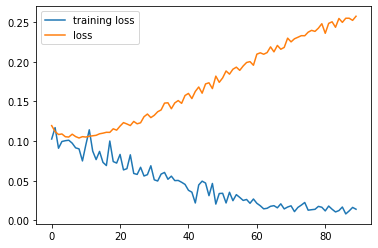

In [11]:
progress[['training loss', 'loss']].plot();

/home/zz/anaconda3/envs/torch_gpu_1.5/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zz/anaconda3/envs/torch_gpu_1.5/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zz/anaconda3/envs/torch_gpu_1.5/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zz/anaconda3/envs/torch_gpu_1.5/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zz/anaconda3/envs/torch_gpu_1.5/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zz/anaco

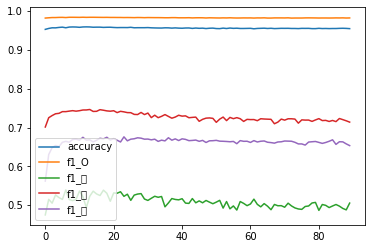

In [12]:
progress[['accuracy', 'f1_O', 'f1_，', 'f1_。', 'f1_？']].plot();
# progress[['accuracy', 'f1_O', 'f1_PERIOD']].plot();

### Model evaluation

In [13]:
bert_punc.load_state_dict(torch.load(os.path.join(path, 'model')))
bert_punc.eval();

In [14]:
batch_size = 200
data_loader_test = create_data_loader(X_test, y_test, False, batch_size)
data_loader_test_asr = create_data_loader(X_test_asr, y_test_asr, False, batch_size)

In [15]:
def predictions(data_loader):
    y_pred = []
    y_true = []
    for inputs, labels in tqdm(data_loader, total=len(data_loader)):
        with torch.no_grad():
            inputs, labels = inputs.cuda(), labels.cuda()
            output = bert_punc(inputs)
            y_pred += list(output.argmax(dim=1).cpu().data.numpy().flatten())
            y_true += list(labels.cpu().data.numpy().flatten())
    return y_pred, y_true

In [16]:
def evaluation(y_pred, y_test):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1, 2, 3])
    overall = metrics.precision_recall_fscore_support(
        y_test, y_pred, average='macro', labels=[1, 2, 3])
    result = pd.DataFrame(
        np.array([precision, recall, f1]), 
        columns=list(['O', 'COMMA', 'PERIOD', 'QUESTION'])[1:], 
        index=['Precision', 'Recall', 'F1']
    )
    result['OVERALL'] = overall[:3]
    return result

In [17]:
# def evaluation(y_pred, y_test):
#     precision, recall, f1, _ = metrics.precision_recall_fscore_support(
#         y_test, y_pred, average=None, labels=[1])
#     overall = metrics.precision_recall_fscore_support(
#         y_test, y_pred, average='macro', labels=[1])
#     result = pd.DataFrame(
#         np.array([precision, recall, f1]), 
#         columns=list(punctuation_enc.keys())[1:], 
#         index=['Precision', 'Recall', 'F1']
#     )
#     result['OVERALL'] = overall[:3]
#     return result

#### Test

In [18]:
y_pred_test, y_true_test = predictions(data_loader_test)
eval_test = evaluation(y_pred_test, y_true_test)
eval_test

100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.490489,0.714421,0.772074,0.658995
Recall,0.574529,0.731945,0.731518,0.679331
F1,0.529193,0.723077,0.751249,0.667840


In [21]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test = pd.DataFrame({
    'COMMA':       [0.655, 0.471, 0.548],
    'PERIOD':       [0.733, 0.725, 0.729],
    'QUESTION':       [0.707, 0.630, 0.667],
    'OVERALL':  [0.700, 0.597, 0.644]
}, index=['Precision', 'Recall', 'F1'])
ref_test

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.655,0.733,0.707,0.700
Recall,0.471,0.725,0.630,0.597
F1,0.548,0.729,0.667,0.644


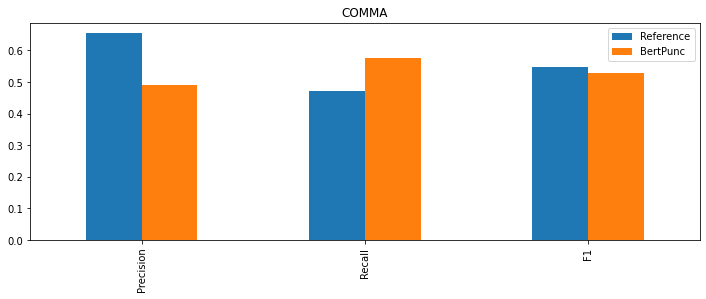

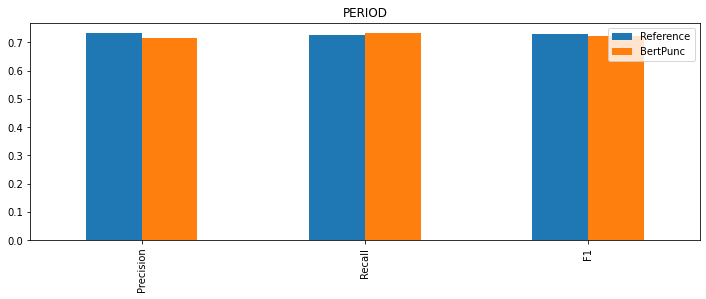

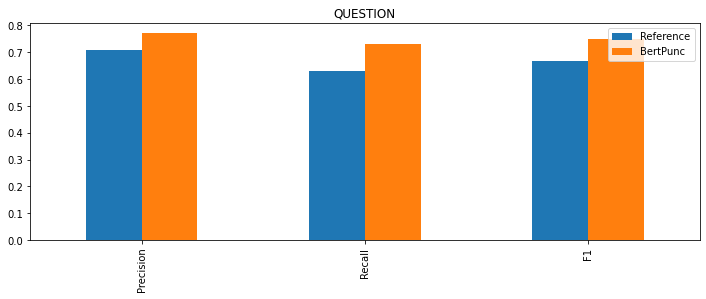

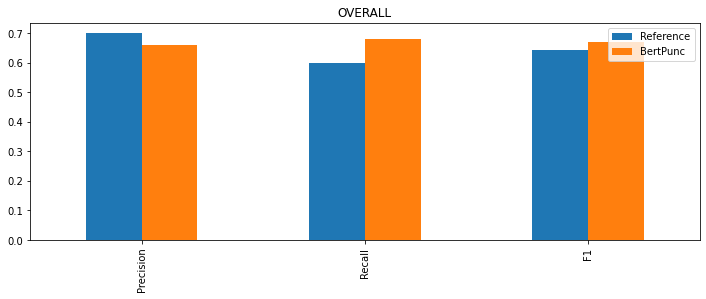

In [22]:
for col in ref_test.columns:
    pd.DataFrame({'Reference': ref_test[col], 'BertPunc': eval_test[col]}).plot.bar(
        title=col, figsize=(12, 4))

#### Test ASR

In [20]:
y_pred_test_asr, y_true_test_asr = predictions(data_loader_test_asr)
eval_test_asr = evaluation(y_pred_test_asr, y_true_test_asr)
eval_test_asr

100%|██████████| 14/14 [00:09<00:00,  1.64it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.485539,0.771995,0.469388,0.575641
Recall,0.694236,0.770087,0.657143,0.707155
F1,0.571429,0.771040,0.547619,0.630029


In [21]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test_asr = pd.DataFrame({
    'COMMA':    [0.596, 0.429, 0.499],
    'PERIOD':   [0.707, 0.720, 0.714],
    'QUESTION': [0.607, 0.486, 0.540],
    'OVERALL':  [0.660, 0.573, 0.614]
}, index=['Precision', 'Recall', 'F1'])
ref_test_asr

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.596,0.707,0.607,0.660
Recall,0.429,0.720,0.486,0.573
F1,0.499,0.714,0.540,0.614


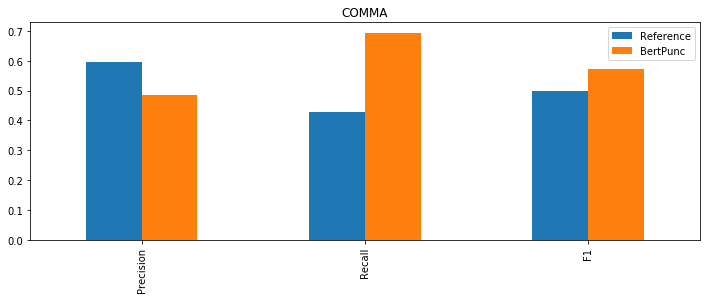

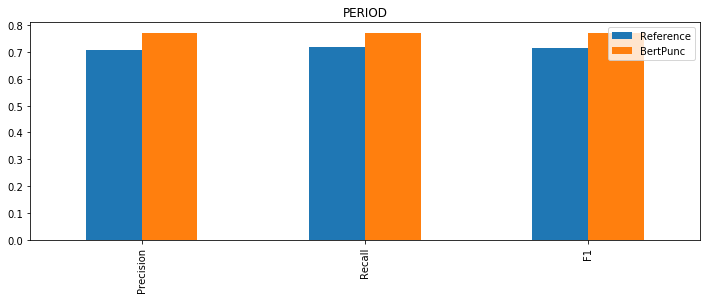

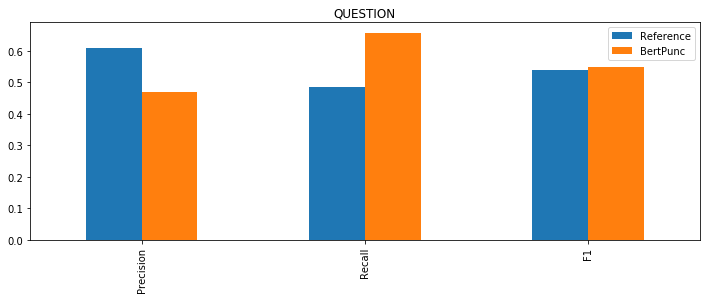

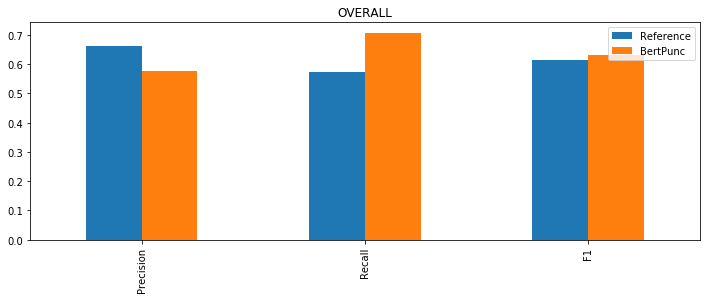

In [22]:
for col in ref_test_asr.columns:
    pd.DataFrame({'Reference': ref_test_asr[col], 'BertPunc': eval_test_asr[col]}).plot.bar(
        title=col, figsize=(12, 4))